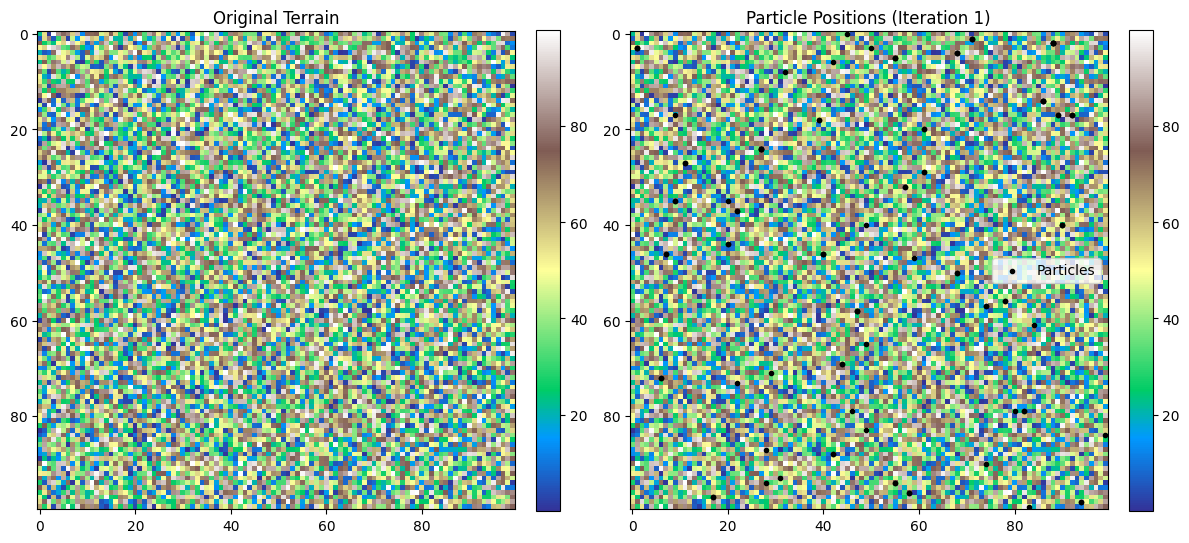

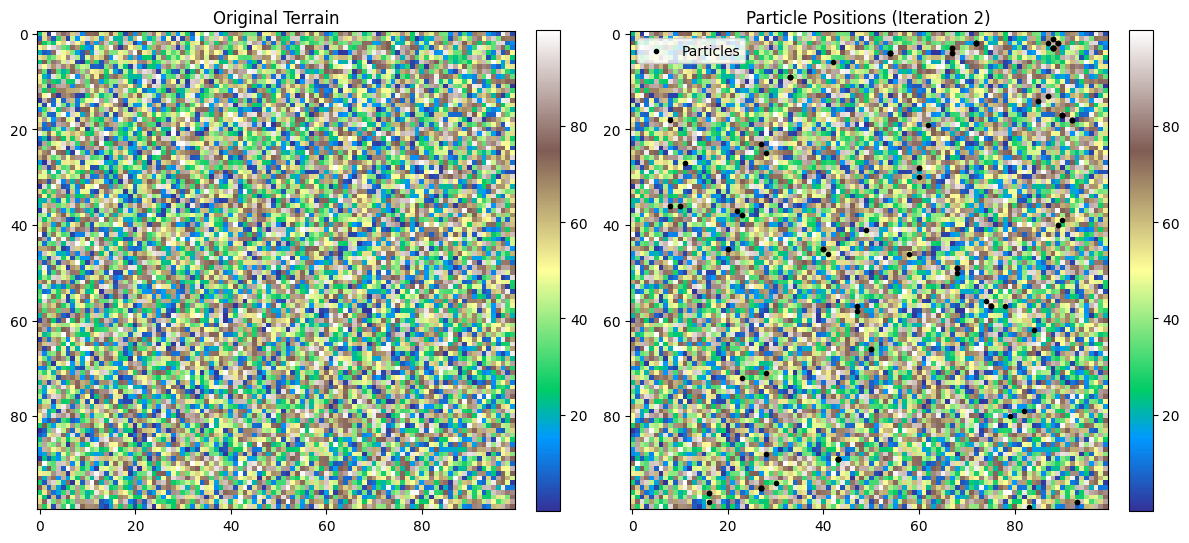

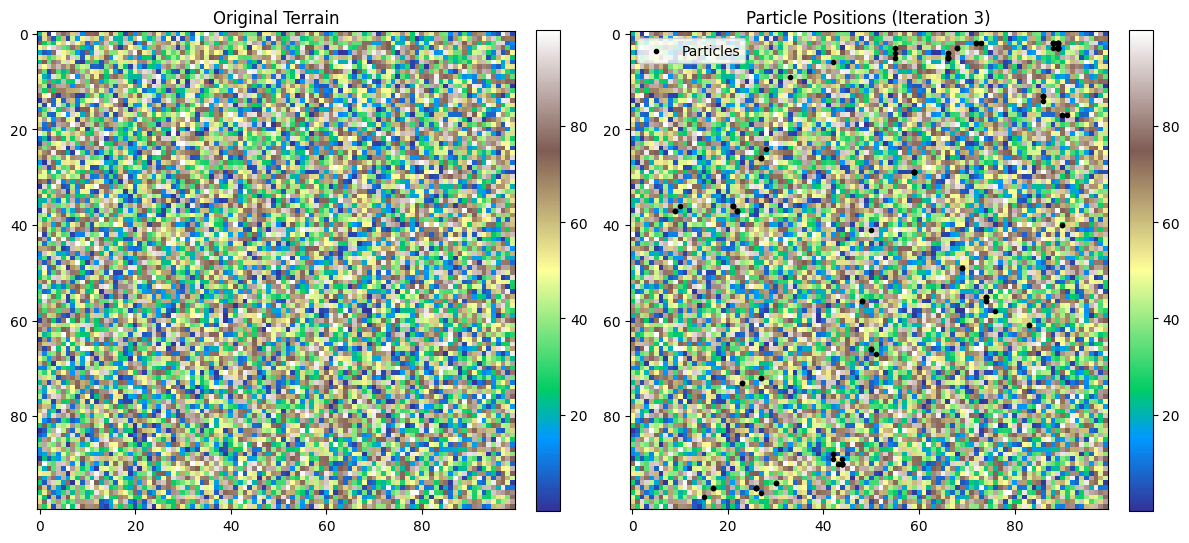

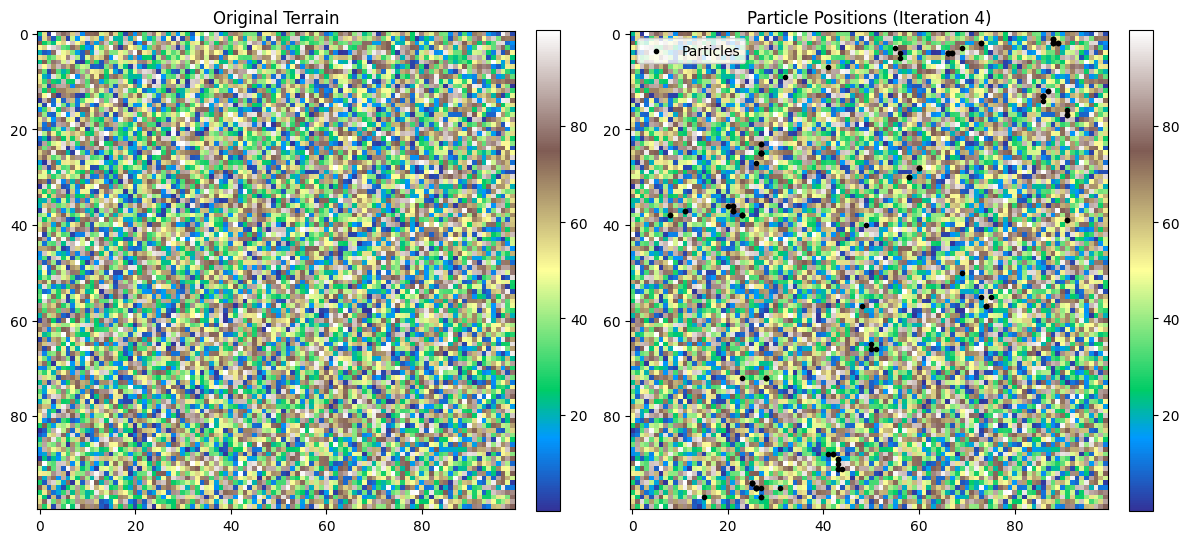

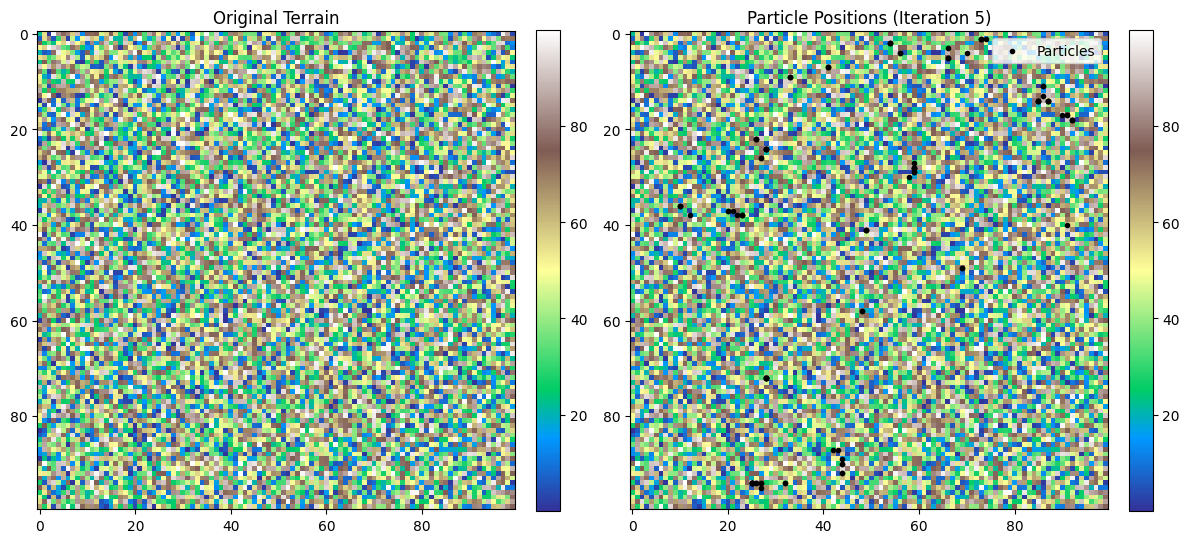

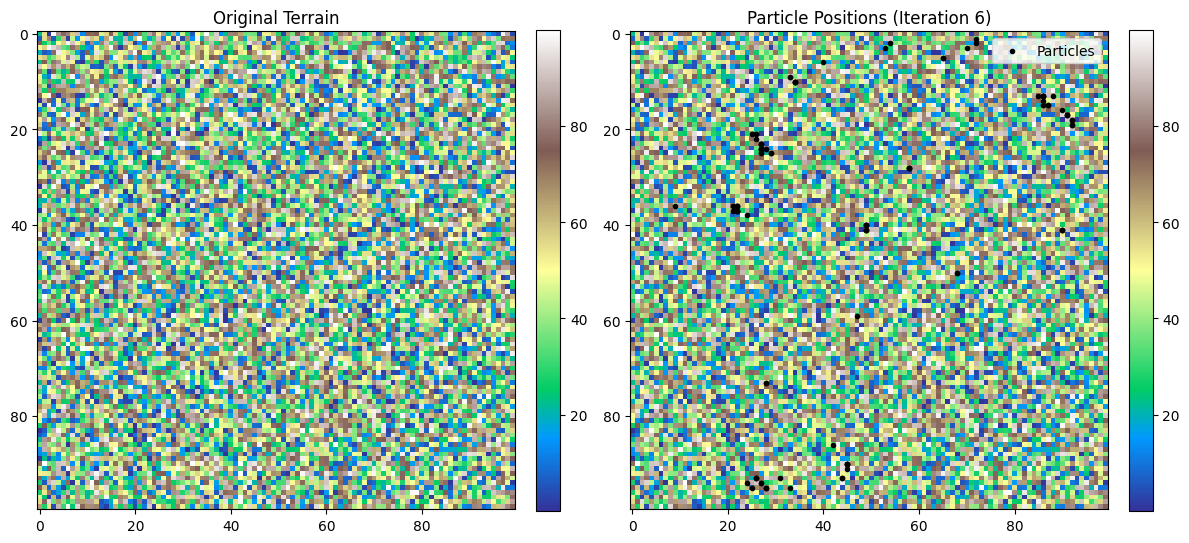

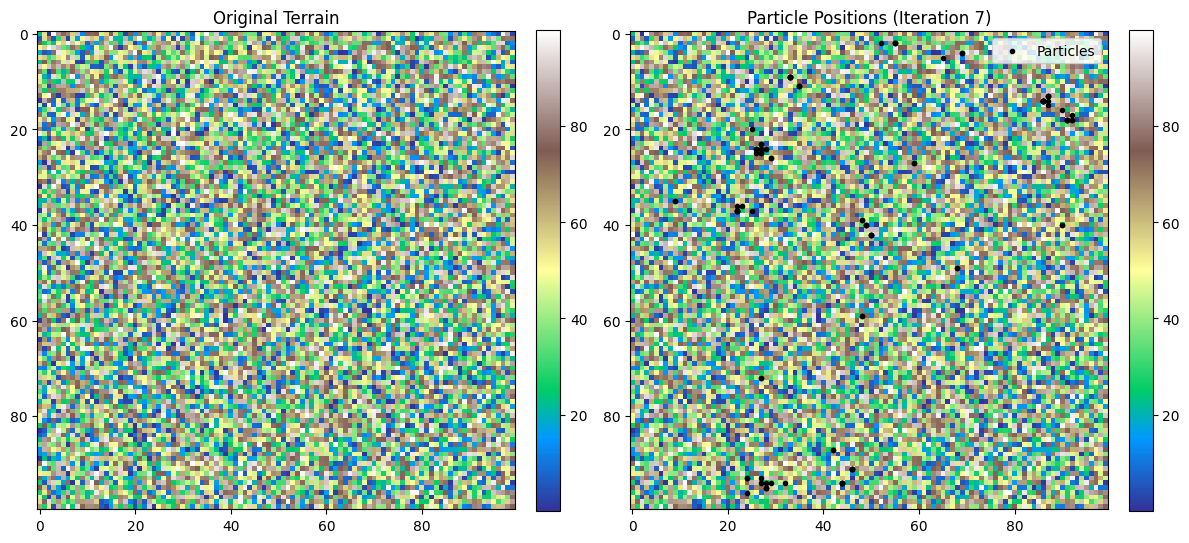

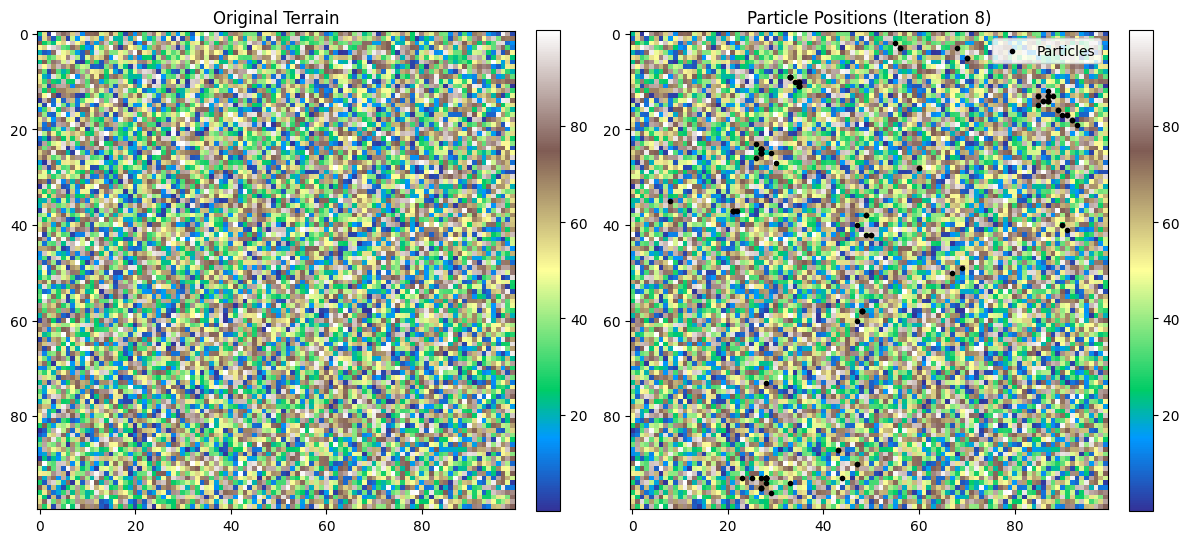

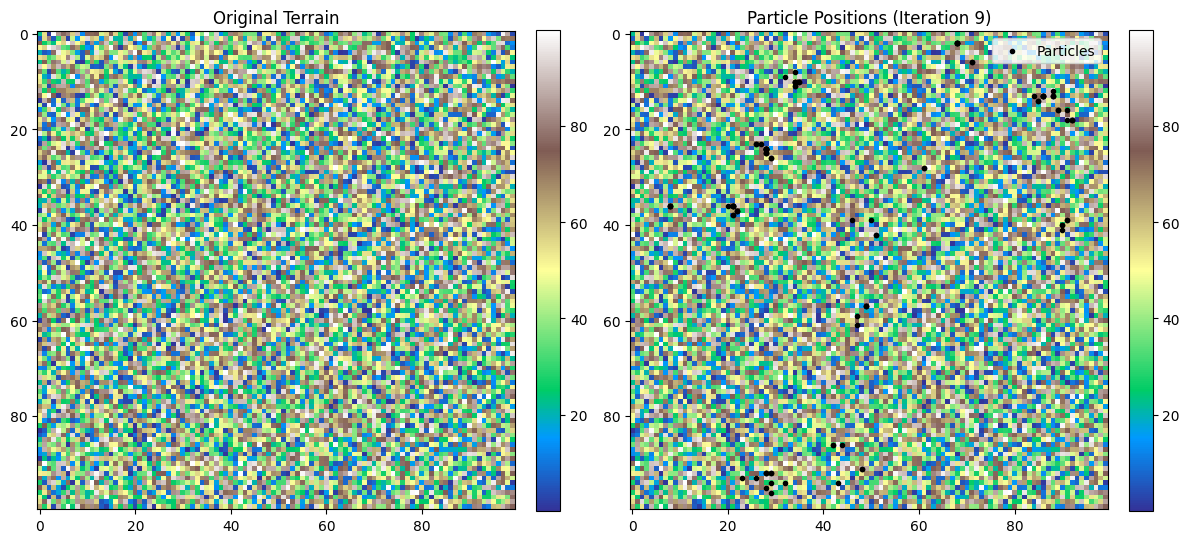

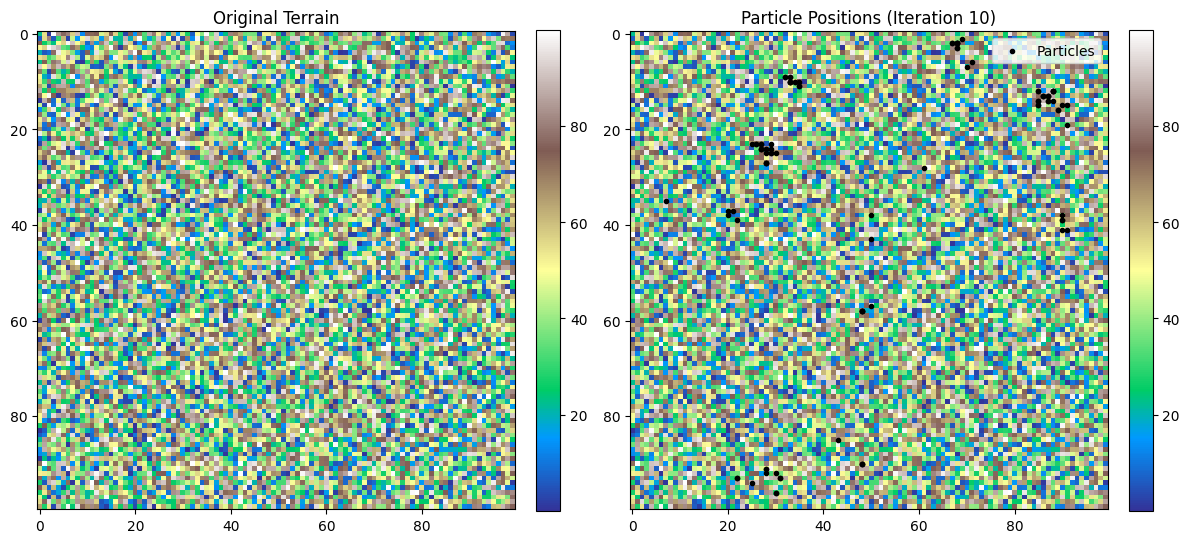

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
GRID_SIZE = 100  # Size of the 3D terrain grid
NUM_PARTICLES = 100  # Number of particles for the particle filter

# Generate random 3D terrain
terrain = np.random.rand(GRID_SIZE, GRID_SIZE) * 100

# Initialize particles
particles = np.random.randint(0, GRID_SIZE, size=(NUM_PARTICLES, 2))

# Perform particle filtering
def particle_filter(terrain, particles):
    particle_weights = np.zeros(NUM_PARTICLES)
    for i in range(NUM_PARTICLES):
        x, y = particles[i]
        particles[i] = [x + np.random.randint(-1, 2), y + np.random.randint(-1, 2)]
        particles[i] = np.clip(particles[i], 0, GRID_SIZE - 1)
        if np.isnan(terrain[particles[i][0], particles[i][1]]):
            particles[i] = np.random.randint(0, GRID_SIZE, size=2)
        # Calculate particle weights based on terrain height
        particle_weights[i] = terrain[particles[i][0], particles[i][1]]

    # Normalize particle weights
    particle_weights /= np.sum(particle_weights)

    # Resample particles based on weights
    indices = np.random.choice(np.arange(NUM_PARTICLES), size=NUM_PARTICLES, replace=True, p=particle_weights)
    particles = particles[indices]

    return particles

# Create graphs based on the obtained results
def create_graphs(terrain, particles, iteration):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original terrain
    im1 = axs[0].imshow(terrain, cmap='terrain')
    axs[0].set_title("Original Terrain")
    fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

    # Plot particle positions
    im2 = axs[1].imshow(terrain, cmap='terrain')
    axs[1].scatter(particles[:, 1], particles[:, 0], c='black', marker='.', label='Particles')
    axs[1].set_title(f"Particle Positions (Iteration {iteration})")
    axs[1].legend()
    fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Perform iterations of particle filtering and create graphs
num_iterations = 10
for i in range(num_iterations):
    particles = particle_filter(terrain, particles)
    create_graphs(terrain, particles, i+1)


In [8]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

map = cv2.imread("map.png",0)
HEIGHT, WIDTH = map.shape
print(map)

rx, ry, rtheta = (WIDTH/4, HEIGHT/4, 0)

[[ 79  80  82 ... 133 148 156]
 [ 78  79  81 ... 138 156 164]
 [ 76  77  79 ... 147 170 180]
 ...
 [181 181 182 ... 174 172 171]
 [178 178 178 ... 180 179 178]
 [177 177 177 ... 183 182 182]]


In [11]:
STEP = 5
TURN = np.radians(25)

def get_input():
  fwd = 8
  turn = 0
  halt = False
  k = cv2.waitKey(0)
  if k == 82:
    fwd = STEP
  elif k == 83:
    turn = TURN
  elif k == 81:
    turn = -TURN
  else:
    halt = True

  return fwd, turn, halt

In [12]:
SIGMA_STEP = 0.5
SIGMA_TURN = np.radians(5)

def move_robot(rx, ry, rtheta, fwd, turn):
  fwd_noisy = np.random.normal(fwd, SIGMA_STEP, 1)
  rx += fwd_noisy*np.cos(rtheta)
  ry += fwd_noisy*np.sin(rtheta)
  print("fwd_noisy = ",fwd_noisy)

  turn_noisy = np.random.normal(turn, SIGMA_TURN, 1)
  rtheta += turn_noisy
  print("turn_noisy = ", np.degrees(turn_noisy))

In [27]:
NUM_PARTICLES = 3000
def init():
    particles = np.random.rand(NUM_PARTICLES, 3)
    particles[:, :2] *= np.array([WIDTH, HEIGHT])
    particles[:, 2] *= np.radians(360)
    return particles


In [14]:
def move_particles(particles, fwd, turn):
  particles[:,0] += fwd*np.cos(particles[:,2])
  particles[:,1] += fwd*np.sin(particles[:,2])
  particles[:,2] += turn

  particles[:,0] = np.clip(particles[:,0], 0.0, WIDTH-1)
  particles[:,1] = np.clip(particles[:,1], 0.0, HEIGHT-1)
  return particles

In [15]:
SIGMA_SENSOR = 2
def sense(x, y, noisy=False):
  x = int(x)
  y = int(y)
  if noisy:
    return np.random.normal(map[y,x], SIGMA_SENSOR, 1)

  return map[y,x]

In [18]:
def compute_weights(particles, robot_sensor):
    num_particles = particles.shape[0]  # Get the number of particles
    errors = np.zeros(num_particles)

    # Calculate the errors between particle elevations and robot sensor reading
    for i in range(num_particles):
        elevation = sense(particles[i, 0], particles[i, 1], noisy=False)
        errors[i] = abs(robot_sensor - elevation)

    weights = np.max(errors) - errors  # Compute the initial weights

    # Apply additional weight adjustment based on particle position
    weights[
        (particles[:, 0] == 0) |
        (particles[:, 0] == WIDTH - 1) |
        (particles[:, 1] == 0) |
        (particles[:, 1] == HEIGHT - 1)
    ] = 0  # Assign zero weight to particles on the boundary

    weights = weights ** 3  # Apply a power transformation to the weights

    return weights


In [20]:
def resample(particles, weights):
    num_particles = particles.shape[0]  # Get the number of particles
    probabilities = weights / np.sum(weights)  # Compute the probabilities

    # Resample particles based on the computed probabilities
    new_indices = np.random.choice(
        num_particles,
        size=num_particles,
        p=probabilities
    )

    particles = particles[new_indices, :]  # Select the particles using the new indices

    return particles


In [21]:
SIGMA_POS = 2
SIGMA_TURN = np.radians(10)
def add_noise(particles):
  noise = np.concatenate(
      (

          np.random.normal(0, SIGMA_POS, (NUM_PARTICLES, 1)),
          np.random.normal(0, SIGMA_POS, (NUM_PARTICLES, 1)),
          np.random.normal(0, SIGMA_TURN, (NUM_PARTICLES, 1))
      ),
      axis = 1
      )
  particles += noise
  return particles

In [22]:
def display(map, rx, ry, particles):
    lmap = cv2.cvtColor(map, cv2.COLOR_GRAY2BGR)

    # Display particles
    if len(particles) > 0:
        for i in range(NUM_PARTICLES):
            cv2.circle(lmap,
                       (int(particles[i,0]), int(particles[i,1])),
                       1,
                       (255,0,0),
                       1)

    # Display robot
    cv2.circle(lmap, (int(rx), int(ry)), 5, (0,255,0), 10)

    # Display best guess
    if len(particles) > 0:
        px = np.mean(particles[:,0])
        py = np.mean(particles[:,1])
        cv2.circle(lmap, (int(px), int(py)), 5, (0,0,255), 5)

    cv2_imshow('map')

In [28]:
particles = init()
while True:
    display(map, rx, ry, particles)
    input_values = get_input()

    # Handle the case where get_input() returns None
    if input_values is None:
        fwd, turn, halt = 0, 0, True
    else:
        fwd, turn, halt = input_values

    if halt:
        break

    rx, ry, rtheta = move_robot(rx, ry, rtheta, fwd, turn)
    particles = move_particles(particles, fwd, turn)

    if fwd != 0:
        robot_sensor = sense(rx, ry, noisy=True)
        weights = compute_weights(particles, robot_sensor)
        particles = resample(particles, weights)
        particles = add_noise(particles)

cv2.destroyAllWindows()
